### 利用卷积神经网络（Convolutional Neural Network，CNN）实现垃圾图片分类

在这个项目中，我们将通过使用`CNN`，对垃圾图片进行高效分类。本数据集包含六种不同类型的垃圾，分别为玻璃、纸、硬纸板、塑料、金属以及一般垃圾，在`"D:\深度学习\data"`目录下。

In [1]:
# type: ignore
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import glob, os, random
import tensorflow as tf
from keras.preprocessing.image import (
    ImageDataGenerator,
    load_img,
    img_to_array,
    array_to_img,
)
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense
from keras.models import Sequential
from keras.models import load_model
from tensorflow.keras import layers, Sequential, regularizers

from tensorflow.keras.optimizers import SGD

#### 1. 加载数据集

    使用 glob 函数来获取指定文件夹下所有 .jpg 格式的图片路径，并打印出图片数量

In [2]:
base_path = "D:\深度学习\data\dataset"
img_list = glob.glob(os.path.join(base_path, "*/*.jpg"))
print(len(img_list))

2527


#### 2. 可视化随机样本

从加载的图像列表中随机选择一些样本，并将其可视化，以便更好地理解数据。
- 使用 random.sample 函数来随机选择 6 张图片进行可视化
- 使用 load_img 函数将图像加载为对象，然后将其转换为 NumPy 数组
- 使用 plt.imshow 函数来显示图像

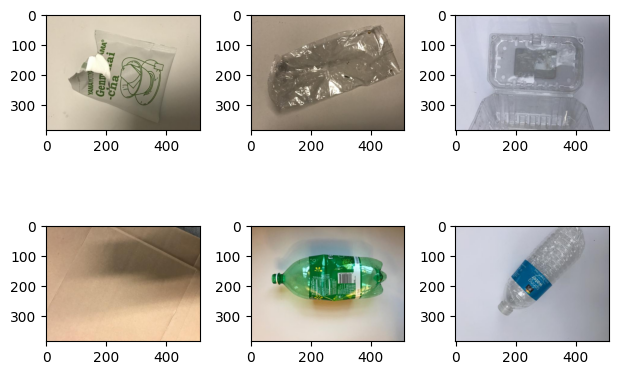

In [3]:
for i, img_path in enumerate(random.sample(img_list, 6)):
    img = load_img(img_path)
    img = img_to_array(img, dtype=np.uint8)

    plt.subplot(2, 3, i + 1)
    # 调整子图布局 https://blog.csdn.net/mighty13/article/details/116147658
    plt.tight_layout()
    plt.imshow(img.squeeze())

#### 3. 数据预处理与生成器

    使用 ImageDataGenerator 对象来创建生成器，将数据预处理步骤包括在内

In [4]:
train_datagen = ImageDataGenerator(
    # 对图片的每个像素值均乘上这个放缩因子，把像素值放缩到0和1之间有利于模型的收敛
    rescale=1.0 / 225,
    # 浮点数，剪切强度（逆时针方向的剪切变换角度）
    shear_range=0.1,
    # 随机缩放的幅度，若为浮点数，则相当于[lower,upper]=[1-zoom_range,1+zoom_range]
    zoom_range=0.1,
    # 浮点数，图片宽度的某个比例，数据提升时图片水平偏移的幅度
    width_shift_range=0.1,
    # 浮点数，图片高度的某个比例，数据提升时图片竖直偏移的幅度
    height_shift_range=0.1,
    # 布尔值，进行随机水平翻转
    horizontal_flip=True,
    # 布尔值，进行随机竖直翻转
    vertical_flip=True,
    # 在 0 和 1 之间浮动。用作验证集的训练数据的比例
    validation_split=0.1,
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.1)

train_generator = train_datagen.flow_from_directory(
    # 提供的路径下面需要有子目录
    base_path,
    # 整数元组 (height, width)，默认：(256, 256)。所有的图像将被调整到的尺寸。
    target_size=(300, 300),
    # 一批数据的大小
    batch_size=32,
    # "categorical", "binary", "sparse", "input" 或 None 之一。
    # 默认："categorical",返回one-hot 编码标签。
    class_mode="categorical",
    # 数据子集 ("training" 或 "validation")
    subset="training",
    seed=0,
)

validation_generator = test_datagen.flow_from_directory(
    base_path,
    target_size=(300, 300),
    batch_size=32,
    class_mode="categorical",
    subset="validation",
    seed=0,
)

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


    输出类别索引的字典。其中键是类别的数字索引，值是对应的类别名称

In [5]:
labels = train_generator.class_indices
labels = dict((v, k) for k, v in labels.items())

print(labels)

{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


#### 4. 构建CNN模型

CNN模型由多个卷积层、池化层和全连接层组成，从而能够逐步提取图像中的特征，并在全连接层中进行分类。

    使用 Sequential 模型，将一系列的卷积层、池化层和全连接层逐一堆叠起来

In [6]:
model = Sequential(
    [
        Conv2D(
            filters=32,
            kernel_size=3,
            padding="same",
            activation="relu",
            input_shape=(300, 300, 3),
        ),
        MaxPooling2D(pool_size=2),
        Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
        MaxPooling2D(pool_size=2),
        Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"),
        MaxPooling2D(pool_size=2),
        Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"),
        MaxPooling2D(pool_size=2),
        Flatten(),
        Dense(64, activation="relu"),
        Dense(6, activation="softmax"),
    ]
)

#### 5. 编译模型

- 使用交叉熵损失函数（categorical_crossentropy）作为目标函数，用于多类别分类问题。
- **优化器选择 Adam/SGD/RMSProp**
- 评估指标选择准确率（acc）

In [7]:
# 编译模型, 采用 compile 函数: https://keras.io/models/model/#compile
model.compile(
    # 损失函数,多分类采用 categorical_crossentropy
    loss="categorical_crossentropy",
    # 优化器, 主要有Adam、sgd、rmsprop等方式
    # optimizer="Adam",
    # optimizer=SGD(learning_rate=1e-3, momentum=0.9),
    optimizer = "rmsprop",
    # 是除了损失函数值之外的特定指标, 分类问题一般都是准确率
    metrics=["acc"],
)

#### 6. 训练模型

    使用生成器 train_generator 和 validation_generator 来训练模型。设置训练轮数为 100 轮，以及适当的批次大小和步数

In [8]:
history = model.fit(
    # 一个生成器或 Sequence 对象的实例
    train_generator,
    # epochs: 整数，数据的迭代总轮数。
    epochs=100,
    # 一个epoch包含的步数,通常应该等于数据集的样本数量除以批量大小。
    steps_per_epoch=2276 // 32,
    # 验证集
    validation_data=validation_generator,
    # 在验证集上,一个epoch包含的步数,通常应该等于数据集的样本数量除以批量大小。
    validation_steps=251 // 32,
)

Epoch 1/100
71/71 [==============================] - 33s 406ms/step - loss: 1.9254 - acc: 0.2317 - val_loss: 1.8201 - val_acc: 0.2054
Epoch 2/100
71/71 [==============================] - 28s 396ms/step - loss: 1.6812 - acc: 0.3012 - val_loss: 1.5480 - val_acc: 0.3929
Epoch 3/100
71/71 [==============================] - 28s 391ms/step - loss: 1.4905 - acc: 0.3908 - val_loss: 1.5569 - val_acc: 0.3884
Epoch 4/100
71/71 [==============================] - 28s 389ms/step - loss: 1.3906 - acc: 0.4366 - val_loss: 1.3087 - val_acc: 0.4821
Epoch 5/100
71/71 [==============================] - 28s 390ms/step - loss: 1.3456 - acc: 0.4688 - val_loss: 1.3340 - val_acc: 0.4688
Epoch 6/100
71/71 [==============================] - 27s 385ms/step - loss: 1.2817 - acc: 0.4942 - val_loss: 1.2117 - val_acc: 0.5223
Epoch 7/100
71/71 [==============================] - 29s 403ms/step - loss: 1.2321 - acc: 0.5236 - val_loss: 1.4050 - val_acc: 0.4420
Epoch 8/100
71/71 [==============================] - 30s 421ms

#### 7. 保存模型

In [9]:
save_model_path = "D:\深度学习\models\model_rmsprop100.h5"  # 保存模型路径和名称
model.save(save_model_path)

#### 8. 模型评估

从验证数据生成器中获取一个批次的测试数据，包括图像数据和相应的真实标签

    这里选择了一个批次的测试数据，即批次编号为 1 的测试数据

In [10]:
test_x, test_y = validation_generator.__getitem__(1)

    使用model.evaluate函数评估模型

In [11]:
loss, accuracy = model.evaluate(test_x, test_y)
print("\nLoss: %.2f, Accuracy: %.2f%%" % (loss, accuracy * 100))

1/1 [==============================] - 0s 186ms/step - loss: 0.6622 - acc: 0.8750

Loss: 0.66, Accuracy: 87.50%


In [12]:
loss, accuracy = model.evaluate(validation_generator)
print("\nLoss: %.2f, Accuracy: %.2f%%" % (loss, accuracy * 100))

8/8 [==============================] - 2s 223ms/step - loss: 1.0576 - acc: 0.7769

Loss: 1.06, Accuracy: 77.69%


    accuracy/loss曲线

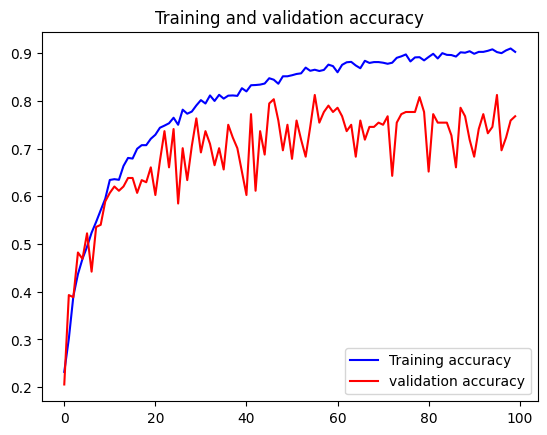

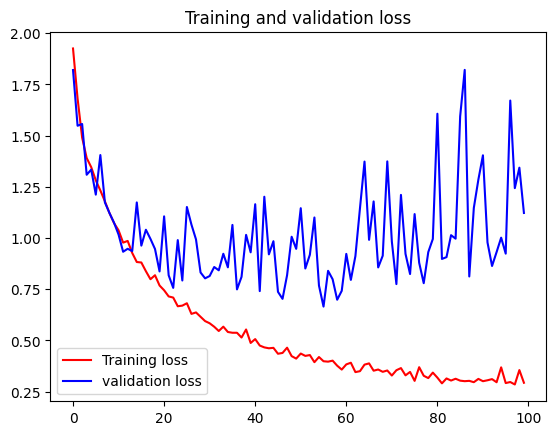

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs,acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### 9. 模型预测

    使用训练好的模型对测试数据进行预测

In [14]:
preds = model.predict(test_x)

    可视化预测结果

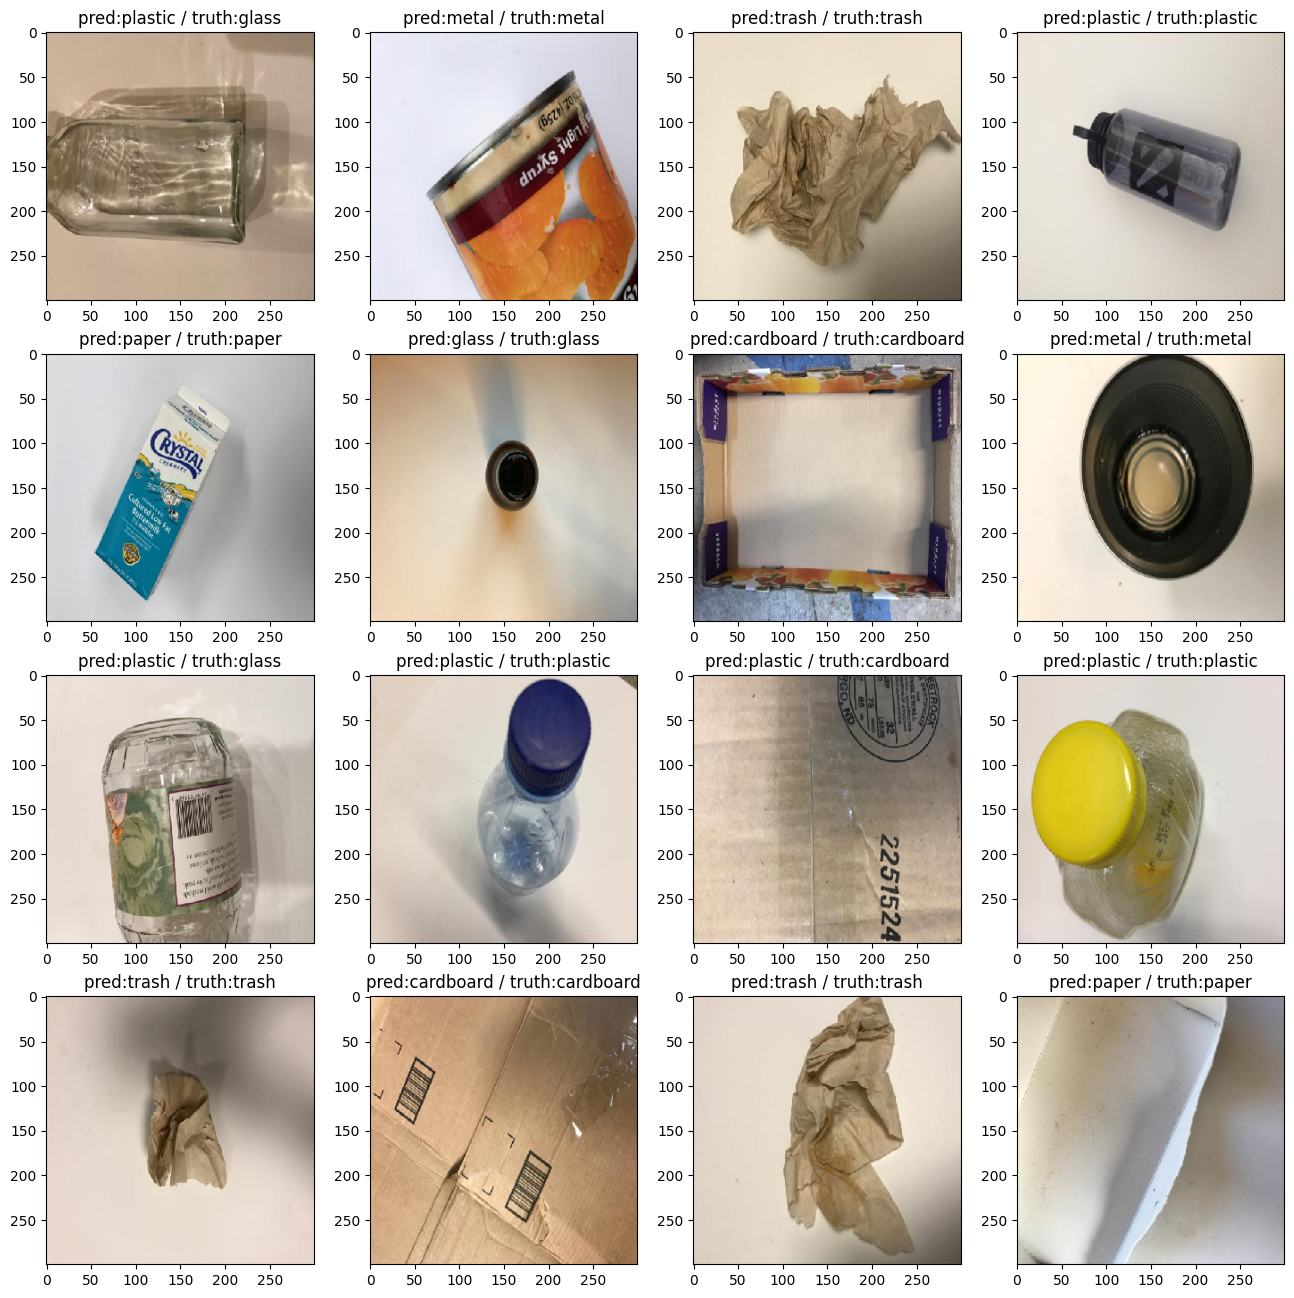

In [15]:
plt.figure(figsize=(16, 16))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.title(
        "pred:%s / truth:%s"
        % (labels[np.argmax(preds[i])], labels[np.argmax(test_y[i])])
    )
    plt.imshow(test_x[i])